<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [198]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [199]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [200]:
data = pd.read_csv('./train.csv')

In [201]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

<h3>Просмотр случайных строчек</h3>

In [202]:
data.sample(n = 10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1448,9,45.40,418.8,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
798,36,93.60,3366.05,Male,0,Yes,No,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0
4488,33,20.10,670.35,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
3007,7,75.10,552.95,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1
5136,6,85.95,514.6,Female,0,No,No,Yes,No,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Mailed check,0
2380,15,84.30,1308.4,Female,0,Yes,No,Yes,No,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,1
2454,4,48.55,201,Male,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4023,39,53.85,2200.7,Male,0,No,No,Yes,Yes,DSL,No,No,No,Yes,No,No,Two year,Yes,Credit card (automatic),0
4866,32,62.45,2045.55,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,No,No,No,Month-to-month,No,Bank transfer (automatic),0
3083,49,99.40,5025,Female,0,Yes,No,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,0


<h3>Просмотр данных в таблице</h3>

In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

<h3>Поиск строк со значениями nan</h3>
<p>Как можно увидеть, в таблице нет строк со значением nan. Проведем более глубокий анализ<p>

In [204]:
data_nan_values = data.isna().sum()  # Table of nan values in data
data_nan_values

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

<p>При детальном изучении таблицы стало видно, что одна колонка - TotalSpent не того типа, который нужен. Она должна быть int64, а сейчас object. Исправим это<p>

In [205]:
try:
    data["TotalSpent"] = pd.to_numeric(data["TotalSpent"])
except:
    print("Unable to parse string " " at position 1048")


Unable to parse string  at position 1048


<p>Появилась ошибка, которая говорит о том, что некоторые ячейки в столбце - это пустые строки. Заменим пустые строки</p>


In [206]:
data.loc[data['TotalSpent'] == " "]



,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


<p> Все строки с пустым значением TotalCount имеют 0 в столбце ClientPeriod. Заменим нули на единицу, а пустые строки на значения из столбика MonthlySpending </p>

In [207]:
data.loc[data['ClientPeriod'] == 0, 'ClientPeriod'] = 1
data.loc[data['TotalSpent'] == " "]


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,1,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,1,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,1,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,1,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,1,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,1,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,1,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,1,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,1,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [208]:
data.loc[data['TotalSpent'] == " ", 'TotalSpent'] = data.loc[data['TotalSpent'] == " "]['MonthlySpending'] 
data.loc[data['TotalSpent'] == data['MonthlySpending']]
data["TotalSpent"] = pd.to_numeric(data["TotalSpent"])

<p>Проверим таблицу на наличие повторяющихся значений</p>

In [209]:
print(data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)
print(data.duplicated().sum())

14
0


## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

<h3>Построим диаграммы для численных признаков</h3>

      ClientPeriod  MonthlySpending  TotalSpent
0               55            19.50     1026.35
1               72            25.85     1872.20
2                1            75.90       75.90
3               32            79.30     2570.00
4               60           115.25     6758.45
...            ...              ...         ...
5263             3            30.40       82.15
5264            50            44.45     2188.45
5265             1            55.05       55.05
5266            29            76.00     2215.25
5267            19            75.90     1375.60

[5268 rows x 3 columns]


Text(0.5, 1.0, 'TotalSpent')

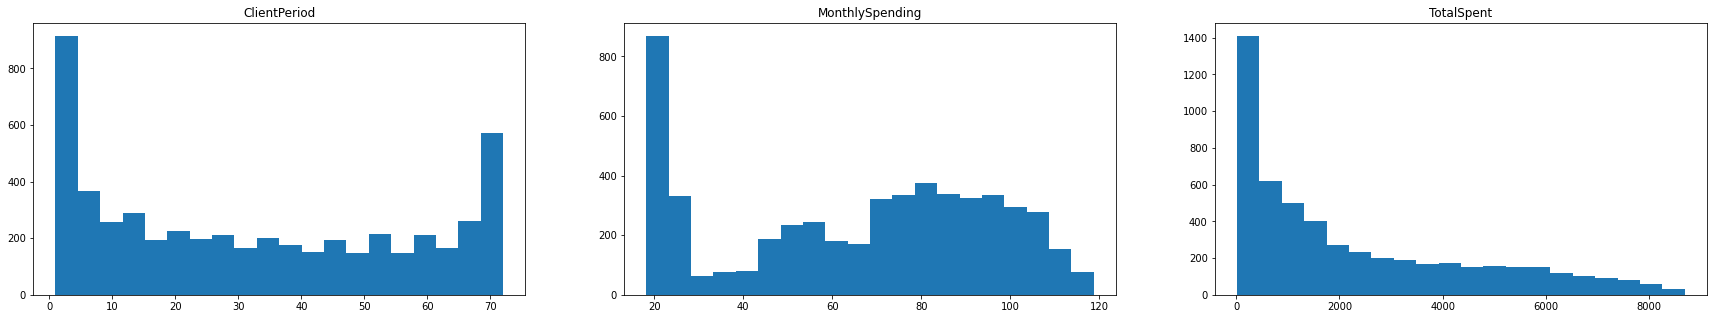

In [210]:
num_data = data[['ClientPeriod', 'MonthlySpending', 'TotalSpent']]
print(num_data)


fig, axs = plt.subplots(1, 3, figsize=(30, 5))
n_bins = len(num_data)
axs[0].hist(num_data['ClientPeriod'], bins=20)
axs[0].set_title('ClientPeriod')
axs[1].hist(num_data['MonthlySpending'], bins=20)
axs[1].set_title('MonthlySpending')
axs[2].hist(num_data['TotalSpent'], bins=20)
axs[2].set_title('TotalSpent')


<h3>

<h3>Подсчет количества каждого значения для каждого признака</h3>

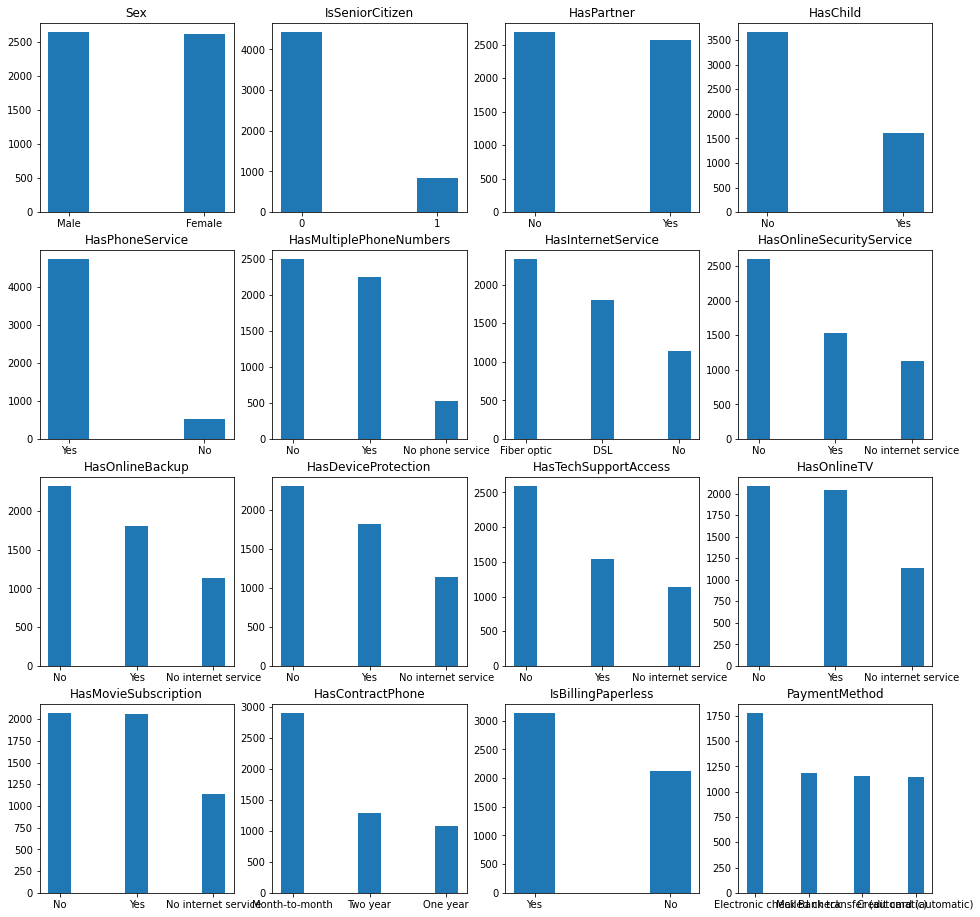

In [211]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
ax = ax.ravel()

for i, col in enumerate(cat_cols):
    ax[i].set_title(col)
    ax[i].bar(np.arange(len(data[col].value_counts().index)), list(data[col].value_counts()), width=0.3)
    ax[i].set_xticks(np.arange(len(data[col].value_counts().index)))
    ax[i].set_xticklabels(list(data[col].value_counts().index))
    






<h3>Распределение целевой переменной и анализ классов на несбалансированность</h3>

[Text(0, 0, '0'), Text(0, 0, '1')]

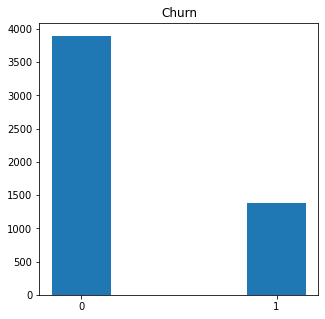

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))


ax.set_title(target_col)
ax.bar(np.arange(len(data[target_col].value_counts().index)), list(data[target_col].value_counts()), width=0.3)
ax.set_xticks(np.arange(len(data[target_col].value_counts().index)))
ax.set_xticklabels(list(data[target_col].value_counts().index))
    

<p>Диаграмма распределение оттока клиентов</p>

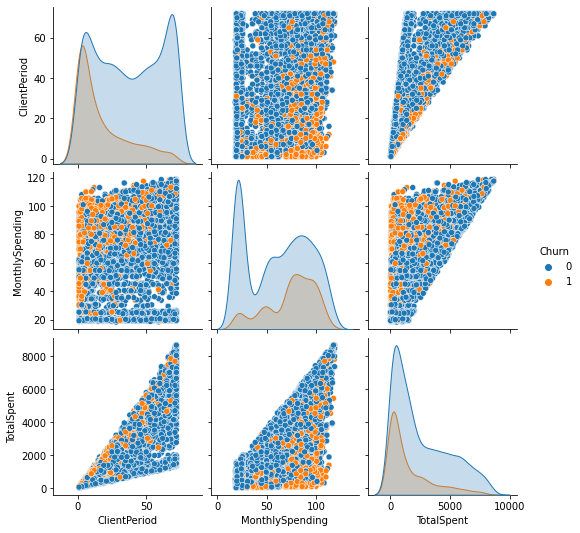

In [213]:
sns.pairplot(data[num_cols + [target_col]], hue=target_col)

<p>Как видно по диаграммам, чем больше люди тратят, тем вероятнее, что они уйдут. Также почти все, кто пользовался сервисом недолгое время, скорее всего, перестали им пользоваться.</p>

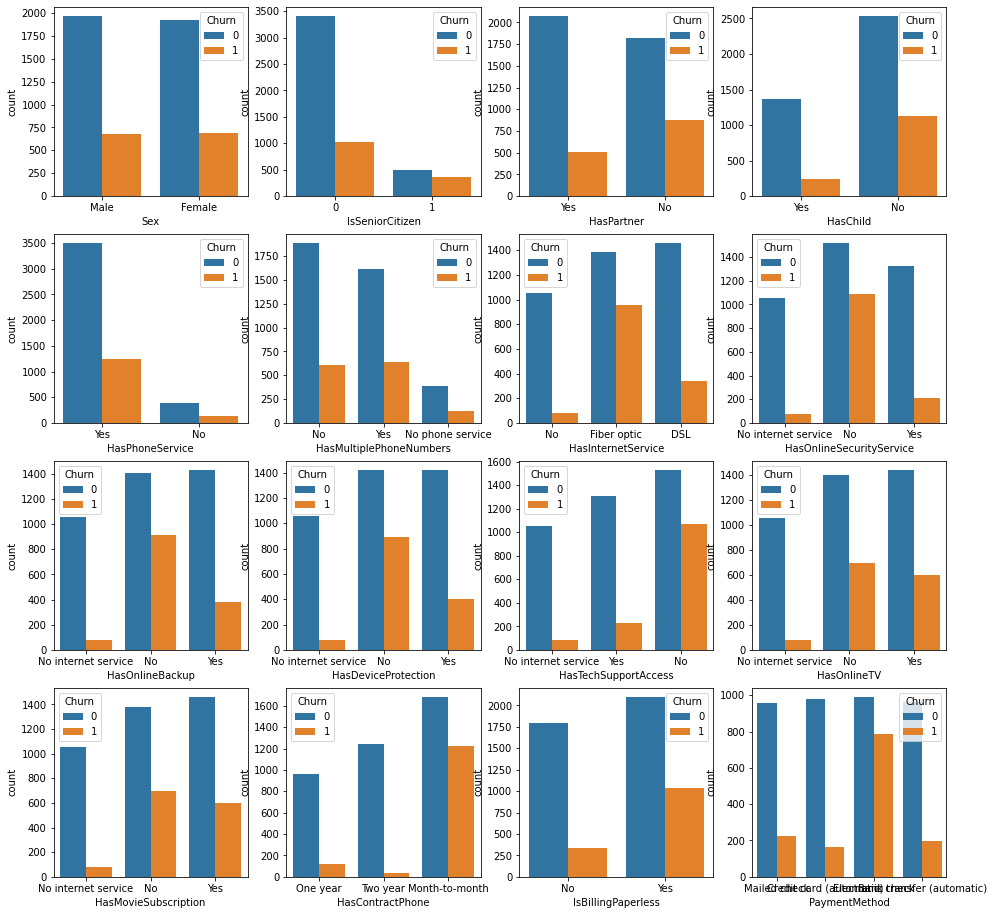

In [214]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
ax = ax.ravel()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue=target_col, data=data, ax=ax[i])

<p> По данным графикам можно сделать некоторое выводы: Мужчины и женщины примерно одинаково перестают быть клиентами сервиса. Люди, у которых нет партнера с большей вероятностью перестанут пользоваться сервисом. Те, у кого нет детей чаще перестают пользоваться сервисом. У кого нет интернета, те не отключаются от сервиса. Если нет сервиса онлайн защиты, то человек, скорее всего, уйдет. Если нет бэкапа, то человек с большей вероятностью уйдет. Нет доступа к тех поддержке - уйдет, нет защиты девайса - уйдет. Некоторые закономерности можно объяснить чисто логически. Напрмер, если у человека нет детей и партнера, то ему почти некому звонить, поэтому он и может уйти. Почти все остальные результаты тоже объяснимы.</p>

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [215]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

1) Обработка данных для того, чтобы к ним можно было применить LogisticRegression. Нормировка числовых признаков, категориальные признаки кодируем с помощью one-hot-encoding'а.

In [240]:
from sklearn import preprocessing
# data1 = data
# data1[num_cols] = preprocessing.normalize(data1[num_cols])
# 
# numeric_data = data1[num_cols]
# 

data1 = data.drop(columns=target_col)
data2 = data1.copy()

scaler = StandardScaler()
data1[num_cols] = scaler.fit_transform(data1[num_cols])


dummy_features = pd.get_dummies(data1[cat_cols])

X = pd.concat([data1[num_cols], dummy_features], axis=1)
X_origin = df.iloc[:, :-1]
X.head()

y = data[target_col]
X

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No,HasOnlineSecurityService_No internet service,HasOnlineSecurityService_Yes,HasOnlineBackup_No,HasOnlineBackup_No internet service,HasOnlineBackup_Yes,HasDeviceProtection_No,HasDeviceProtection_No internet service,HasDeviceProtection_Yes,HasTechSupportAccess_No,HasTechSupportAccess_No internet service,HasTechSupportAccess_Yes,HasOnlineTV_No,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.918163,-1.507219,-0.558518,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1
1,1.611337,-1.296767,-0.185702,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0
2,-1.283682,0.361992,-0.977436,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,-0.019660,0.474675,0.121859,1,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
4,1.122038,1.666131,1.967953,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263,-1.202132,-1.145971,-0.974682,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
5264,0.714289,-0.680325,-0.046312,0,0,1,0,1,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0
5265,-1.283682,-0.329020,-0.986626,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
5266,-0.141985,0.365306,-0.034500,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0


2) С помощью кроссвалидации или разделения на train/valid выборку протестируем разные значения гиперпараметра C и выберем лучший по метрике ROC-AUC.

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    train_size=0.8,
                                                    random_state=42)


parameters = {"C": [100, 10, 1, 0.1, 0.01, 0.001, 2, 3, 4, 5, 6]}

CV_model = GridSearchCV(LogisticRegression(max_iter=10000), 
                        parameters,
                        cv=5, 
                        scoring='roc_auc',
                        n_jobs=-1, 
                        verbose=10)
CV_model.fit(X_train, y_train)
means = CV_model.cv_results_['mean_test_score']
error = CV_model.cv_results_['std_test_score']
print(CV_model.best_params_)
print(CV_model.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0827s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    3.0s finished


{'C': 10}
0.8446086607502507


Лучшее качество - 0.8446086607502507 с какими параметром С = 10



## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [244]:
#!pip install catboost
from catboost import CatBoostClassifier

X_train_origin, X_test_origin, _, _ = train_test_split(data2, y, 
                                                       train_size=0.8, 
                                                       random_state=42)

boosting_model = catboost.CatBoostClassifier(cat_features=cat_cols,
                                             eval_metric='AUC',
                                             verbose=False)

boosting_model.fit(X_train_origin, y_train)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

print(train_auc, test_auc)


0.891759567525481 0.8441690874855555


При использовании catboost результат получился 0.8441690874855555 на тестовой выборке и 0.891759567525481 на тренировочной

<h3>Вывод</h3>
<p> Модели работают примерно одинаково
Так как обе модели работают почти одинаково, то возьмем catboost для предсказаний</p>

# Предсказания

In [249]:
best_model = boosting_model

In [250]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')


submission['Churn'] = best_model.predict_proba(X_test)[:, 1]

submission.to_csv('./submission_final.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.